In [76]:
import sys
import math
from collections import namedtuple
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

plt.rcParams['figure.figsize'] = [8, 5]

In [77]:

Point = namedtuple("Point", ['x', 'y'])

def length(point1, point2):
    return math.sqrt((point1.x - point2.x)**2 + (point1.y - point2.y)**2)

def objec(solution,points):
    nodeCount=len(points)
    obj = length(points[solution[-1]], points[solution[0]])
    for index in range(0, nodeCount-1):
        obj += length(points[solution[index]], points[solution[index+1]])
    return obj

def greedy_solve(points,s_node,k_nn):
    nodeCount=len(points)
    # visit the unvisited node that is closest to current node
    vis_list=[]
    # starts on random node
    #c_node=random.randint(0,nodeCount-1)
    c_node=s_node
    vis_list.append(c_node)
    for i in tqdm(range(nodeCount-1)):
        #checks available nodes
        av_nodes = [n for n in list(range(0,nodeCount)) if n not in vis_list]
        # first choose k_nn and check availability
        found=0
        # go through k_nn starting closest to c_node and check if available
        for i in k_nn[c_node]:
            if i in av_nodes:
                found=1
                next_node=i
                break
            else:
                next_node = min(av_nodes,key=lambda x:length(points[c_node],points[x]))
        # update current node        
        c_node=next_node
        vis_list.append(c_node) 
    solution = vis_list
    return solution

def sol_plot(solution,points):
    nodeCount=len(points)
    # plot the solution
    j=0
    for i in points:
        plt.plot(i.x, i.y,'ko')
        #plt.annotate(j,(i.x, i.y))
        j=j+1
    
    for i in range(-1, nodeCount-1):
        plt.plot((points[solution[i]].x, points[solution[i+1]].x),
                 (points[solution[i]].y, points[solution[i+1]].y),'-')
    
def data_plot(points):
    nodeCount=len(points)
    # plot the solution
    j=0
    for i in points:
        plt.plot(i.x, i.y,'rx')
        #plt.annotate(j,(i.x, i.y))
        j=j+1

def reverse_if_better(tour, i, j, k, points):
    # Given tour [...A-B...C-D...E-F...]
    ordered = sorted([i,j,k])
    i = ordered[0]
    j = ordered[1]
    k = ordered[2]
    A, B = points[tour[i-1]], points[tour[i]]
    C, D = points[tour[j-1]], points[tour[j]]
    E, F = points[tour[k-1]], points[tour[k % len(tour)]]
    d0 = length(A, B) + length(C, D) + length(E, F)
    d1 = length(A, C) + length(B, D) + length(E, F)
    d2 = length(A, B) + length(C, E) + length(D, F)
    d3 = length(A, D) + length(E, B) + length(C, F)
    d4 = length(F, B) + length(C, D) + length(E, A)
    new_tour = tour
    if d0 > d1:
        new_tour[i:j] = reversed(tour[i:j])
        return new_tour, -d0 + d1
    elif d0 > d2:
        new_tour[j:k] = reversed(tour[j:k])
        return new_tour, -d0 + d2
    elif d0 > d4:
        new_tour[i:k] = reversed(tour[i:k])
        return new_tour, -d0 + d4
    elif d0 > d3:
        print('this!')
        tmp = tour[j:k] + tour[i:j]
        new_tour[i:k] = tmp
        return new_tour, -d0 + d3
    return new_tour, 0

def random_3_opt(tour, i, j, k, points):
    # Given tour [...A-B...C-D...E-F...]
    A, B = points[tour[i-1]], points[tour[i]]
    C, D = points[tour[j-1]], points[tour[j]]
    E, F = points[tour[k-1]], points[tour[k % len(tour)]]
    new_tour = list(tour)
    i = random.randrange(3)
    if i == 0:
        new_tour[i:j] = reversed(tour[i:j])
        return new_tour
    elif i == 1:
        new_tour[j:k] = reversed(tour[j:k])
        return new_tour
    elif i == 2:
        new_tour[i:k] = reversed(tour[i:k])
        return new_tour
    
def compute_k_neighbors(k,points):
    nodeCount=len(points)
    k_nn=[]
    if(k>nodeCount):
        k=nodeCount
    for i in tqdm(range(nodeCount)):
        nn=sorted(range(nodeCount),key=lambda x:length(points[i],points[x]))
        nn=nn[1:k+1]
        k_nn.append(nn)
    return k_nn
    
def sim_anneal(s0,points,k_nn,T0=60,alpha=0.9995,maxit=30000, m_length=1, stop_thld=1000):
    s=s0
    T=T0
    nodeCount=len(points)    
    #calculate objective of solution
    obj=objec(s,points)
    
    best_obj=obj
    best_s=s
    
    a_prob_hist=[]
    obj_hist=[]
    T_hist=[]
    
    stop_clk=0
    
    for i in range(maxit):       
        obj_hist.append(obj)
        T_hist.append(T)       
        p_s=s
        
        # 3OPT NEIGHBORHOOD STEP
        # get 3 random nodes 
        n1,n2,n3=random.sample(range(nodeCount),3)

        p_s = random_3_opt(s,n1,n2,n3,points)
        p_obj=objec(p_s,points)
        # calculates acceptance probability
        if p_obj<obj:
            a_prob=1
        else:
            a_prob=math.exp(-(p_obj-obj)/T)
        a_prob_hist.append(a_prob)
        # ROLL THE DICE!
        if a_prob>random.uniform(0, 1):
            s=p_s
            #alpha=p_obj/obj
            obj=p_obj
        # saves best solution    
        if obj<best_obj:
            best_s=s
            best_obj=obj
            stop_clk=0
        else:
            stop_clk=stop_clk+1
            
        # stop if no improvement is made 
        if stop_clk>=stop_thld:
            break
        
        T=T*alpha
    return s,best_s, a_prob_hist, obj_hist, T_hist

def threeopt_annealing(input_data,greedy=False,k=1000):
    # parse the input
    lines = input_data.split('\n')

    nodeCount = int(lines[0])

    print('Node Count:',nodeCount)

    points = []
    for i in range(1, nodeCount+1):
        line = lines[i]
        parts = line.split()
        points.append(Point(float(parts[0]), float(parts[1])))
    print('Points Parsed!')
    
    #compute k nearest neighbors
    k_nn=compute_k_neighbors(k,points)
    print('Neighbor matrix ready!')
    
    if greedy==True:
        # gets random greedy solution
        starting_node=random.randint(0,nodeCount)
        solution=greedy_solve(points,starting_node,k_nn)
        print('Greedy Ready!')
        s0=solution      
    else:
        s0=random.sample(range(nodeCount), nodeCount)

    greedy_sol=s0
    # find an improved solution with simulated annealing 2-opt neighborhood

    
    # NOTE1: Relate temperature with edge_length (Uncertain, perhaps unnecessary)
    # NOTE2: Try doing grid searched annealing runs and get the best (TOO EXPENSIVE ON THE FLY)
    # NOTE3: Include swaps in the neighborhood (WORSE THAN 2OPT)
    # NOTE4: Keep track of best solution and break if it doesn't improve for a while,
    #        afterwards do new SA run with different parameters. (May be surpassed by good sched.)
    # NOTE5: Use cached k-nearest neighbors instead of full nearest neighbors
    # NOTE6: Implement 2-OPT Heuristic and check runtime (BAD)
    # NOTE7: Keep list of k-nearest neighbors, in SA: 1.select random node, 2. select random
    #        node from nearest neighbor list, 3. perform 2opt swap and submit    
    
    sa_maxit=40
    a_prob_hist=[]
    obj_hist=[]
    T_hist=[]
    #T0=100
    best_ever_s=s0
    best_s=s0
    s=s0
    obj_clk=0
    best_thld=2
    if nodeCount<900:
    	if nodeCount<300:
    		if nodeCount<=100:
    			stop_thld=50000
    			sa_maxit=100
    			best_thld=3
    		else:
    			stop_thld=40000
    			sa_maxit=300
    			best_thld=3
    	else:
    		stop_thld=20000
    		sa_maxit=100
    		best_thld=10
    else:
    	if nodeCount>20000:
    		stop_thld=40000
    		sa_maxit=1
    		best_thld=1
    	else:
    		stop_thld=40000 
    		sa_maxit=15
    		best_thld=1
    T0=max([objec(s0,points)/nodeCount, 15])

    for i in range(sa_maxit):
        #print('T0:',T0,' Current Best:',objec(best_ever_s,points),'Starting State Obj:',objec(s,points), i, '/', sa_maxit )
        print('T0: %.2f | Best: %.2f | Starting obj: %.2f | it %d/%d' 
              %(T0, objec(best_ever_s,points), objec(s,points), i+1, sa_maxit ) )
        s, best_s, a_p_hist, o_hist, T1_hist = sim_anneal(s,points,k_nn,T0,alpha=0.9999,
                                              maxit=100000,stop_thld=stop_thld)

        a_prob_hist.extend(a_p_hist)
        obj_hist.extend(o_hist)
        T_hist.extend(T1_hist)        
        #T0=objec(s,points)/nodeCount
        T0=T0*0.4
        if objec(best_s,points)<objec(best_ever_s,points):
            best_ever_s=best_s
            obj_clk=0
        else:
        	obj_clk=obj_clk+1

        if obj_clk>=best_thld:
        	s=best_ever_s
        	obj_clk=0
        	T0=max([objec(s0,points)/nodeCount, 15])
        	print('>Node Reset<')   	

        #Checks if satisfies course requirements

    # Do a cooling full run
    #print('Cooling Run, Starting obj.= %.2f' %objec(best_ever_s,points))
    #T0=max([objec(s0,points)/nodeCount, 50])
    #ph1, last_r, ph2, ph3, ph4=sim_anneal(best_ever_s,points,k_nn,T0,alpha=0.999,
    #                                              maxit=200000,stop_thld=40000)
    


    print('Start Obj:',objec(s0,points))
    print('End Obj:',objec(best_ever_s,points))
    print('Delta Obj:',objec(s0,points)-objec(best_ever_s,points))
    
    # plot solution
    plt.subplot(2,2,1)
    plt.semilogy(T_hist)
    plt.grid(1)
    
    #sol_plot(greedy_sol,points)
    #start_list=[points[starting_node]]
    #make new points list
    #for i in k_nn[starting_node]:
    #    start_list.append(points[i])
    #data_plot(start_list)
    
    plt.subplot(2,2,2)
    sol_plot(best_ever_s,points)
    
    plt.subplot(2,2,3)
    plt.plot(a_prob_hist,'.')
    
    plt.subplot(2,2,4)
    plt.plot(obj_hist)
    plt.grid(1)
    
    obj=objec(best_ever_s,points)
    solution=best_ever_s
    # prepare the solution in the specified output format
    output_data = '%.2f' % obj + ' ' + str(0) + '\n'
    output_data += ' '.join(map(str, solution))

    return output_data


In [87]:
def teste(input_data):
    # parse the input
    lines = input_data.split('\n')

    nodeCount = int(lines[0])

    print('Node Count:',nodeCount)

    points = []
    for i in range(1, nodeCount+1):
        line = lines[i]
        parts = line.split()
        points.append(Point(float(parts[0]), float(parts[1])))
    print('Points Parsed!')
    
    s0=list(range(nodeCount))
    print(s0)
    s0_obj=objec(s0,points)
    print('s0 obj:',s0_obj)
    
    plt.subplot(1,2,1)
    sol_plot(s0,points)
    
    n1,n2,n3=random.sample(range(nodeCount),3)
    #n1,n2,n3=0,4,1
    print('nodes:',n1,n2,n3)
    p_s,cost = reverse_if_better(s0,n1,n2,n3,points)
    print(p_s)
    p_obj=objec(p_s,points)
    print('ps obj:',p_obj)
    
    plt.subplot(1,2,2)
    sol_plot(p_s,points)


Node Count: 51
Points Parsed!
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
s0 obj: 1313.4683444443458
nodes: 14 7 49
[0, 1, 2, 3, 4, 5, 6, 13, 12, 11, 10, 9, 8, 7, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
ps obj: 1300.4832541442806
None


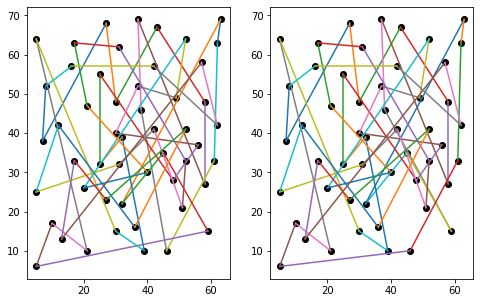

In [98]:
import os
notebook_path = os.path.abspath("Notebook.ipynb")
data_path = os.path.join(os.path.dirname(notebook_path), "data\\tsp_51_1")

if len(data_path) > 1:
    file_location = data_path.strip()
    with open(file_location, 'r') as input_data_file:
        input_data = input_data_file.read()
        #print(threeopt_annealing(input_data))
        print(teste(input_data))
